# **Initialize Environment**

In [1]:
!git clone https://github.com/nithin-seenivasan/twitter-analysis

import os
os.chdir("twitter-analysis")

Cloning into 'twitter-analysis'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 45 (delta 14), reused 6 (delta 2), pack-reused 0
Unpacking objects: 100% (45/45), done.


Add the config.py file here, if the API key is required. It's not on Github, since I don't want to expose API key there. 

In [2]:
!pip install -r requirements.txt

     |████████████████████████████████| 58 kB 6.3 MB/s 
     |████████████████████████████████| 4.0 MB 37.1 MB/s 
     |████████████████████████████████| 88 kB 7.3 MB/s 
     |████████████████████████████████| 1.6 MB 54.8 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.8 MB 56.2 MB/s 
     |████████████████████████████████| 77 kB 6.7 MB/s 
     |████████████████████████████████| 895 kB 60.5 MB/s 
     |████████████████████████████████| 596 kB 57.7 MB/s 
     |████████████████████████████████| 6.6 MB 57.2 MB/s 
     |████████████████████████████████| 1.1 MB 64.3 MB/s 
     |████████████████████████████████| 162 kB 72.3 MB/s 
     |████████████████████████████████| 181 kB 66.3 MB/s 
     |████████████████████████████████| 144 kB 49.9 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created whee

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import umap
import gensim.downloader as api
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import sklearn.cluster as cluster
from sklearn import metrics
from scipy import stats

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import scripts.TextAnalysis as ta
from scripts.api import *




import scripts.TextAnalysis as ta
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import codecs  #this let's us display tweets properly (emojis, etc.)

pd.set_option("display.max_colwidth", None)


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


#Basic Data Manipulation

##### Load Tweets 

In [4]:
fname_db = "data/300k_ghostofkiev_acad_22feb_13apr"  #database filenmae (without .db extension)

df = DB.fetch(table_name='keyword_tweets', path=fname_db)

In [ ]:
df.head(2)

,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo,entities
0,2022-03-08T23:58:47.000Z,None,@vpkivimaki The new ghost of Kiev.,en,0,0,0,0,1501346723628732418,1415540067452473346,1501342968313176064,22245277,nan,"{'mentions': [{'start': 0, 'end': 11, 'username': 'vpkivimaki', 'id': '22245277'}], 'annotations': [{'start': 29, 'end': 32, 'probability': 0.7363, 'type': 'Place', 'normalized_text': 'Kiev'}]}"
1,2022-03-08T23:52:21.000Z,None,Story behind Ghost of Kiev 🤦‍♂️😂😂 https://t.co/opzWGFUqvd,en,1,0,5,0,1501345107722788878,1493051240850284549,1501345107722788878,nan,nan,"{'annotations': [{'start': 22, 'end': 25, 'probability': 0.2601, 'type': 'Place', 'normalized_text': 'Kiev'}], 'urls': [{'start': 34, 'end': 57, 'url': 'https://t.co/opzWGFUqvd', 'expanded_url': 'https://twitter.com/Marckovvvvv2/status/1501345107722788878/video/1', 'display_url': 'pic.twitter.com/opzWGFUqvd'}]}"


##### Add Created at Datetime column (to sort by)

In [5]:
df_keyword = DB.fetch(table_name='keyword_tweets', path=fname_db)
print(f"{len(df_keyword)} keyword tweets")

format = "%Y-%m-%d %H:%M:%S"
df_keyword ['created_at_datetime'] = pd.to_datetime(df_keyword ['created_at'],format=format).dt.tz_localize(None)
df_keyword .sort_values(by = 'created_at_datetime', inplace = True, ascending = True)
df_keyword ['tweet_indicator'] = np.ones(len(df_keyword ))
df_keyword ['rate_1D'] = df_keyword .rolling('1D',on = 'created_at_datetime').sum()['tweet_indicator']
df_keyword ['rate_7D'] = df_keyword .rolling('7D',on = 'created_at_datetime').sum()['tweet_indicator']/7

26693 keyword tweets


In [6]:
from google.colab import files

df_keyword.to_csv('gok_unprocessed.csv', encoding = 'utf-8-sig') 
files.download('gok_unprocessed.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#####Time Series Plot (rate of new tweets)

Insight: Trend peaked around 28 Feb 2022, and started to fall immediately after that. This was around the time news outlets started publishing articles debunking the claims. 

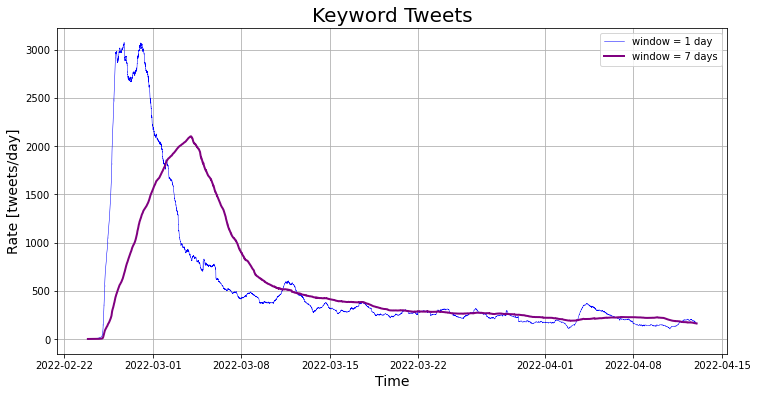

In [7]:
fig = plt.figure(figsize = (12,6))
sns.lineplot(data = df_keyword , x = 'created_at_datetime',y = 'rate_1D',label = 'window = 1 day',linewidth = .5,color = 'blue')
sns.lineplot(data = df_keyword , x = 'created_at_datetime',y = 'rate_7D',label = 'window = 7 days', linewidth = 2,color = 'purple')

plt.grid()
plt.xlabel("Time", fontsize = 14)

plt.ylabel("Rate [tweets/day]", fontsize = 14)
#plt.xlim(datetime.date(2020, 10, 1),datetime.date(2021,1,1))
#plt.ylim([0,30])
plt.title(f"Keyword Tweets",fontsize = 20)

plt.legend()
plt.show()

#####Sort by Date - what were the first 25 tweets?

In [8]:
df_keyword[['created_at_datetime','text', 'like_count']].sort_values(by = ['created_at_datetime'], ascending = True).head(n=25)

,created_at_datetime,text,like_count
24766,2022-02-23 20:38:41,"@varbmos @peterdaou Oh my God, this is so Russiagate all over again. One part of the DC ghost story kind of checks out and then you're insane to remember we were promised faked gas attacks and tanks rolling into Kiev.",0
24765,2022-02-24 03:20:16,"Live view from Kyiv, Ukraine.\n\nGhost town.\n\nPrayers for all of Ukraine.\n\nSource: https://t.co/66v0XT1QeW https://t.co/VV6MqUTsjN",3
24764,2022-02-24 07:51:18,"Should I call out of work tomorrow???\n""Sorry, kids. Couldn't come to class last time bc Russia's attacking Kiev half a world away and I'm very antsy about it for reasons that are beyond your understanding rn. But anyways, let's keep writing our Ghost Chicken Nuggets adventure.""",6
24763,2022-02-24 10:15:40,"@daisyelfling This will be a fait acompli over in a few days, all land east of the Dniper will be occupied and Kiev a ghost town on the border",0
24762,2022-02-24 12:15:40,Ghost of kiev https://t.co/DAMmmYxFxB,2
24761,2022-02-24 13:04:48,"@JobeerBa PARAPHRASING: THE EMPTY BRAVADO OF UKRAINE , AND BEHIND THEM is the cowardly SHOE BIDEN, &amp; its western flank with an EMPTY MURMUR, IT IS NOW CLEAR WITH THIS SCENE of THE CAPITAL KIEV #كييف HAS BECOME A GHOST TOWN PREPARING TO RECEIVE PUTIN'S SOLDIERS",1
24760,2022-02-24 13:36:26,Television pictures of ghost town Kiev blaring air raid sirens is absolutely frightening. It's not a false alarm !,1
24759,2022-02-24 16:01:38,"@soluTium1 @GobHenMLDL @SexymhieQ @AJAYRIAH66 @UnitedPatriot22 @WongLi2515 @EyeEres @FhqJackie @ligaya2021 @AltNiSam1 @MissyLizah78 @ACCTV4 @spartacusfilip @Grumpy_YO @raincyrainy @GrowlHarhar @gwapoarawaraw @LoVe_MeOw_24 @itsmeLJHeart @LheysanpI @maine_worldwide @TalaZaldivar @ABCancaloo @DolorNolet @MDSOnwardPH22 @iamshoberamos @NileSneel @choy_kapitan @archerqueen2 @Jjcruz2 @2021_raine @rolem03_chick @ApatheticDame @Battousai0522 @Proudly__pinay @IHateFakePple @GoldDaMalditass @Ms_Trizzia_ @LilMsMalditaMD @wonderbingboom @CarpeDiem_IAm @glaced2perfexn @gracia_licious @bplorienne1 @grazzeem @KimIndar @YesYesYo13 @ZayWhaat @pads_nosi Kiev, Ukraine capital is a ghost town.. residents are scrambling and fleeing the city.. long line of vehicles going out of the city..\n\nChernobyl nuclear plant is now a target of Russian attack..\n\nUkraine offers weapons to anyone who wants to fight..",8
24758,2022-02-24 16:39:14,"@LBC @ShelaghFogarty LBC radio, Tony Connelly, reports now that Kiev is starting to look like a ghost town. Some residents have headed to Poland for shelter. There have been reports that soldiers may be trying to take control of the Chernobyl Nuclear Power plant. LBC radio will keep you informed.",0
24757,2022-02-24 17:08:25,Ghost of Kiev https://t.co/qSYeoAGOmZ,0


Insight: First tweet with major engagemet was on 2022-02-24 18:12:14, with 55 likes. There were a couple of tweets about it before, but the accounts have been since deleted (SUSPICIOUS!)

#####Sort the tweets by like count. 

  Print out the screen name, text, and like count of the top five tweets in descending order (only print these three columns).

In [9]:
df_keyword[['created_at_datetime','text', 'like_count', 'retweet_count']].sort_values(by = ['like_count'], ascending = False).head(n=10)

,created_at_datetime,text,like_count,retweet_count
22870,2022-02-25 21:23:28,“ghost of kiev is fake!!” idc its cool,25406,1144
19346,2022-02-27 06:21:39,This is the ghost of kiev https://t.co/RU8zDuZsR3,8414,751
23400,2022-02-25 17:45:10,"Pilot who shot down six enemy planes, he was nicknamed ""The Ghost of Kiev"".\nBig honour. Hero of Ukraine.\n#hero #ukraine #stopwar https://t.co/L5WjhneaUY",6220,682
26315,2022-02-25 17:33:33,Come on Ghost of Kyiv 🇺🇦 you are fu….hero ✊🏼 #StayWithUkraine #ghostofkiev,5589,236
23246,2022-02-25 18:37:46,"Pilot who shot down six enemy planes, he was nicknamed \n""The Ghost of Kiev"". Big honour.\n Hero of Ukraine.#Ghost of Kyiv #UkraineInvasion #Ukrainian #worldwar3 https://t.co/SiDHB2KdY1",5395,485
16007,2022-02-28 15:53:28,"#war A 🇺🇦Ukrainian pilot 'Vladmir Abdonov' has downed 6 🇷🇺Russian jets over 🇺🇦Ukraine:\n2x SU-35\n2x SU-25\n1x SU-27\n1x MIG-29\n\nThe Ace of the 21st Century!\nTo the country of Ukraine, and the rest of the world you are:\n“THE GHOST OF KYIV”\n#Kyiv #Kiev\n#Ukraine #Russia #ghostofkyiv https://t.co/n1voE9Dhw6",5040,733
5162,2022-03-20 00:50:55,They all have 1 thing in common: \n\n- Snake island\n- Ghost of Kiev\n- Theatre of Mariupol\n- Miss Ukraine fighter girl\n- Magomed killed by Ukrainian SOF\n- Siege Mariupol has been broken\n- Zelensky 3 times almost assassinated \n\nIt never happened.,5012,1161
22178,2022-02-26 01:53:35,The Ghost Of Kyiv 🇺🇦\n#Ukraine #UkraineUnderAttack #Kiev https://t.co/JoS7cEMHc1,4614,483
23880,2022-02-25 12:01:37,"@visegrad24 Three Ukranians actions have bought me to tears today. The Ghost of Kiev, the Snake Island response to Russian warship, and Vitaly Skakun.\nAbsolute fkn heroes.",4569,364
24715,2022-02-25 00:27:03,Reportedly an Ukrainian jet has been nicknamed the ‘Ghost of Kyiv’ (kiev) in his victories over multiple Russian troops. #ukraine https://t.co/OkxQTDxbWj,4354,380


Insight: ((See SMA Project Plan for the data supporting the following insights):

1.   Most liked tweet was from 25.02.22 (25k likes, 1.1k retweets) 
2.   Range of dates where most engagement was generated was between 25 and 27 Feb 
3.   Total engagement from top 10 tweets: 73695 likes, 5370 retweets
4.   There is a mix of memes (2 tweets), tweets suggesting it is "cool" despite being fake (1 tweet), tweets calling out fake news (1 tweet) MIXED with the fake news (6 tweets)






#####Sort the tweets by Retweet count. 

Print out the screen name, text, and Retweet count of the top five tweets in descending order (only print these three columns).

In [10]:
df_keyword[['created_at_datetime','text', 'like_count', 'retweet_count']].sort_values(by = ['retweet_count'], ascending = False).head(n=10)

,created_at_datetime,text,like_count,retweet_count
5162,2022-03-20 00:50:55,They all have 1 thing in common: \n\n- Snake island\n- Ghost of Kiev\n- Theatre of Mariupol\n- Miss Ukraine fighter girl\n- Magomed killed by Ukrainian SOF\n- Siege Mariupol has been broken\n- Zelensky 3 times almost assassinated \n\nIt never happened.,5012,1161
22870,2022-02-25 21:23:28,“ghost of kiev is fake!!” idc its cool,25406,1144
11023,2022-03-04 20:09:43,Snake Island 13\nGhost of Kiev\nUkrainian Reaper\nBabi Yar bombing\nNuke plant bombing\n\nWhat else are they lying about?,3230,793
19346,2022-02-27 06:21:39,This is the ghost of kiev https://t.co/RU8zDuZsR3,8414,751
16007,2022-02-28 15:53:28,"#war A 🇺🇦Ukrainian pilot 'Vladmir Abdonov' has downed 6 🇷🇺Russian jets over 🇺🇦Ukraine:\n2x SU-35\n2x SU-25\n1x SU-27\n1x MIG-29\n\nThe Ace of the 21st Century!\nTo the country of Ukraine, and the rest of the world you are:\n“THE GHOST OF KYIV”\n#Kyiv #Kiev\n#Ukraine #Russia #ghostofkyiv https://t.co/n1voE9Dhw6",5040,733
23400,2022-02-25 17:45:10,"Pilot who shot down six enemy planes, he was nicknamed ""The Ghost of Kiev"".\nBig honour. Hero of Ukraine.\n#hero #ukraine #stopwar https://t.co/L5WjhneaUY",6220,682
1754,2022-04-03 20:16:48,"Snake Island 13: fake\nGhost of Kiev: fake\nChernobyl bombing: fake\nNuclear plant fight: fake\n""Bombing"" of Babi yar: fake\n\nMeanwhile, their neo fascists go on Telegram and flex about their war crimes.\n\nBy default, I don't believe any of the stuff happening over there. Verify it 1st",2004,627
23246,2022-02-25 18:37:46,"Pilot who shot down six enemy planes, he was nicknamed \n""The Ghost of Kiev"". Big honour.\n Hero of Ukraine.#Ghost of Kyiv #UkraineInvasion #Ukrainian #worldwar3 https://t.co/SiDHB2KdY1",5395,485
22178,2022-02-26 01:53:35,The Ghost Of Kyiv 🇺🇦\n#Ukraine #UkraineUnderAttack #Kiev https://t.co/JoS7cEMHc1,4614,483
26658,2022-02-25 03:22:26,"Ukraine,\n\nI pray for your success.\n#ghostofkiev https://t.co/LaOCxmzWMA",2532,444


Insight: Sorting by retweet_count also gets similar insights as with likes. Key point to note is that the top liked and retweeted tweet (that is not calling out Fake news) is from 2/25/2022  9:23:28 PM

#####Create Wordcloud of entire dataset

In [11]:
stopwords = set(STOPWORDS)##

df = DB.fetch(table_name= 'keyword_tweets', path = fname_db) #fetch the table named "user_tweets" at path fname_db to dataframe called "df"
#df = df[['screen_name', 'text']] #remove all columns except these two (overwrite function)
df['text_clean'] = df.text.apply(ta.clean_tweet) #Create new column called "text_clean" 
df = df[df.text_clean.str.len() > 0]

n = len(df)
print(f"There are {n} tweets in the dataframe")
df.sample(n=5)


There are 26693 tweets in the dataframe


,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo,entities,text_clean
13906,2022-03-01T19:05:41.000Z,None,@stone_toss @wigger @TuckerCarlson Ghost of Kiev.\nA joke Made un Argentina.\nCan't believe how far it went,en,0,0,1,0,1498736249661759492,1168548378592055297,1498674512660946948,873051724604334080,nan,"{'mentions': [{'start': 0, 'end': 11, 'username': 'stone_toss', 'id': '873051724604334080'}, {'start': 12, 'end': 19, 'username': 'wigger', 'id': '548258435'}, {'start': 20, 'end': 34, 'username': 'TuckerCarlson', 'id': '22703645'}], 'annotations': [{'start': 44, 'end': 47, 'probability': 0.4342, 'type': 'Place', 'normalized_text': 'Kiev'}, {'start': 65, 'end': 73, 'probability': 0.8332, 'type': 'Place', 'normalized_text': 'Argentina'}]}",stonetoss wigger tuckercarlson ghost of kieva joke made un argentinacant believe how far it went
24169,2022-02-25T06:12:43.000Z,None,@Jigstermon Su35 in ukriane now is already fake su27 fake mig29 fake.. \nOnly su25 and su24 are used a d maybe the ghost of kiev is already dead https://t.co/819uorGRgm,en,0,2,1,0,1497092173464059917,1336942201243373568,1497091656230662145,1158314975707844610,nan,"{'mentions': [{'start': 0, 'end': 11, 'username': 'Jigstermon', 'id': '1158314975707844610'}], 'urls': [{'start': 144, 'end': 167, 'url': 'https://t.co/819uorGRgm', 'expanded_url': 'https://twitter.com/MotorinoSupremo/status/1497092173464059917/photo/1', 'display_url': 'pic.twitter.com/819uorGRgm'}]}",jigstermon su35 in ukriane now is already fake su27 fake mig29 fake only su25 and su24 are used a d maybe the ghost of kiev is already dead
11841,2022-03-03T17:16:25.000Z,None,@MZagotynskyi @CNN Oh and you always get a response like this or a pic of Zelensky/the ghost of Kiev as a response which both are proven fake. Or footage of soldiers you can clearly tell are acting (look at rifle) 😂 https://t.co/gTkkJDHCuW,en,0,2,0,0,1499433525497454594,717890305954070528,1499431705895133185,1125782834009059330,nan,"{'annotations': [{'start': 74, 'end': 81, 'probability': 0.5634, 'type': 'Person', 'normalized_text': 'Zelensky'}, {'start': 96, 'end': 99, 'probability': 0.7568, 'type': 'Place', 'normalized_text': 'Kiev'}], 'mentions': [{'start': 14, 'end': 18, 'username': 'CNN', 'id': '759251'}], 'urls': [{'start': 216, 'end': 239, 'url': 'https://t.co/gTkkJDHCuW', 'expanded_url': 'https://twitter.com/itwilljustwait/status/1499433525497454594/video/1', 'display_url': 'pic.twitter.com/gTkkJDHCuW'}]}",mzagotynskyi cnn oh and you always get a response like this or a pic of zelenskythe ghost of kiev as a response which both are proven fake or footage of soldiers you can clearly tell are acting look at rifle
9931,2022-03-06T17:36:07.000Z,None,@KevinWNewman @TheFakeJoshHuff @christogrozev 😂 maybe they looking for the ghost of Kiev,en,0,0,4,0,1500525648095420421,4605708202,1500437812906188800,143125974,nan,"{'mentions': [{'start': 0, 'end': 13, 'username': 'KevinWNewman', 'id': '143125974'}, {'start': 31, 'end': 45, 'username': 'christogrozev', 'id': '144611647'}], 'annotations': [{'start': 85, 'end': 88, 'probability': 0.6673, 'type': 'Place', 'normalized_text': 'Kiev'}]}",kevinwnewman thefakejoshhuff christogrozev maybe they looking for the ghost of kiev
24891,2022-03-12T15:24:04.000Z,None,"@sergiusthebest @indigopin @curiousgeorgie_ @RepJohnConyers Don't underestimate the Ukrainian propaganda machine, either. #snakeisland #ghostofkiev",en,0,0,2,0,1502666744569155586,108435488,608981664107229184,1125626707,nan,"{'mentions': [{'start': 0, 'end': 15, 'username': 'sergiusthebest', 'id': '1125626707'}, {'start': 16, 'end': 26, 'username': 'indigopin', 'id': '2635197969'}, {'start': 27, 'end': 43, 'username': 'curiousgeorgie_', 'id': '1303770780338204672'}, {'start': 44, 'end': 59, 'username': 'RepJohnConyers', 'id': '138770045'}], 'hashtags': [{'start': 122, 'end': 134, 'tag': 'snakeisland'}, {'start': 135, 'end': 147, 'tag': 'ghostofkiev'

In [12]:
stopwords.add("Ghost")
stopwords.add("Kiev")
stopwords.add("Ghostofkiev")
stopwords.add("Ukraine")
stopwords.add("Ukrainian")
stopwords.add("Russia")

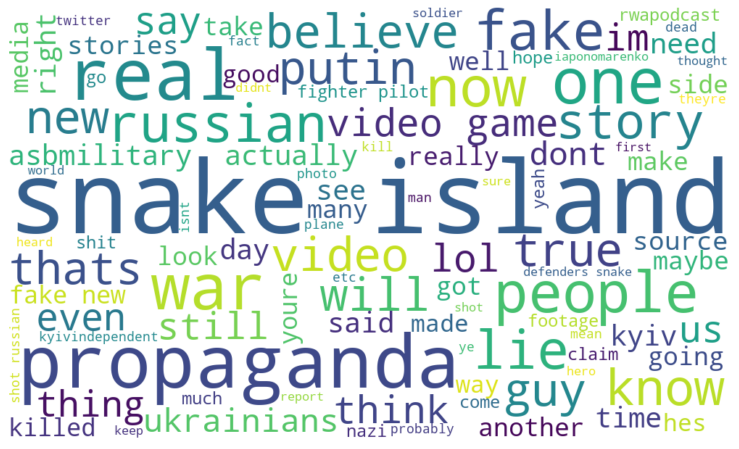

In [13]:
text=' '.join(df.text_clean.tolist()).lower()
wordcloud = WordCloud(stopwords=stopwords,max_font_size=150, max_words=100, background_color="white",width=1000, height=600)
wordcloud.generate(text)
plt.figure(figsize = (32,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Insight: Kinda cool that GoK wordcloud shows Snake Island as a major trend

#Sentiment Analysis of Entire Dataset

#####Initialization of Model

In [14]:
%%time
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

CPU times: user 13.8 s, sys: 2.48 s, total: 16.2 s
Wall time: 17.3 s


In [15]:
def sentiment_classifier(text,model,tokenizer):
    inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)

    token_type_ids = inputs['token_type_ids']
    input_ids = inputs['input_ids']

    output = model(input_ids, token_type_ids=token_type_ids,return_dict=True,output_hidden_states=True)
    logits = np.array(output.logits.tolist()[0])
    prob = np.exp(logits)/np.sum(np.exp(logits))
    sentiment = np.sum([(x+1)*prob[x] for x in range(len(prob))])  #use this line if you want the mean score
    
    return sentiment

In [16]:
%%time
c = 0
Sentiment = []
for index,row in df.iterrows():  #iterate over rows of dataframe
    c+=1
    if c%1000==0:print(f"Tweet {c}/{len(df)}")  #print progres every 1000 rows

    sentiment = sentiment_classifier(row.text,model,tokenizer)  #calculate sentiment and embedding of tweet
    Sentiment.append(sentiment)  #append sentiment of tweet to Sentiment list

df['sentiment'] = Sentiment  #add sentiment column to dataframe of tweets
df.head()

Tweet 1000/26693
Tweet 2000/26693
Tweet 3000/26693
Tweet 4000/26693
Tweet 5000/26693
Tweet 6000/26693
Tweet 7000/26693
Tweet 8000/26693
Tweet 9000/26693
Tweet 10000/26693
Tweet 11000/26693
Tweet 12000/26693
Tweet 13000/26693
Tweet 14000/26693
Tweet 15000/26693
Tweet 16000/26693
Tweet 17000/26693
Tweet 18000/26693
Tweet 19000/26693
Tweet 20000/26693
Tweet 21000/26693
Tweet 22000/26693
Tweet 23000/26693
Tweet 24000/26693
Tweet 25000/26693
Tweet 26000/26693
CPU times: user 1h 13min 10s, sys: 31.4 s, total: 1h 13min 42s
Wall time: 1h 13min 24s


#####Mean sentiment of all tweets

In [17]:
mean_opinion = df['sentiment'].mean()
print(f"Mean opinion of the tweets:{mean_opinion}")

Mean opinion of the tweets:2.5492129131680623


#####Sentiment Distribution of entire Dataset

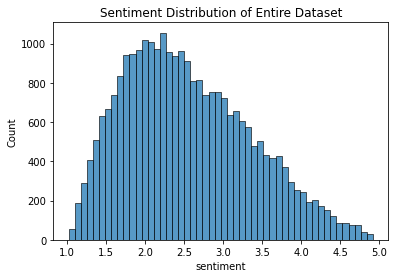

In [18]:
  df_plot = df
  sns.histplot(data=df_plot, x = "sentiment")
  plt.title(f"Sentiment Distribution of Entire Dataset")
  plt.show()

Insight: Lots of negative words such as "killed", "war", "soldiers" pull the sentiments down. Most tweets cluster around the 2-2.5 range. 

In [19]:
df['star']=df.sentiment.round(0)

In [20]:
df.sample(3)

,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo,entities,text_clean,sentiment,star
13678,2022-03-01T22:07:49.000Z,None,@Feynixis @reaIIytrash You must be one of those who believes in ghost of kiev,en,0,0,0,0,1498782084193787909,3055663858,1498766726372155399,2782981742,nan,"{'mentions': [{'start': 0, 'end': 9, 'username': 'Feynixis', 'id': '2782981742'}, {'start': 10, 'end': 22, 'username': 'reaIIytrash', 'id': '477374415'}]}",feynixis reaiiytrash you must be one of those who believes in ghost of kiev,2.717080,3.0
2912,2022-03-28T19:10:26.000Z,None,@Cernovich Russians are being lied to by their propaganda. They aren't allowed to hear about true stories like the ''Snake Island'' and ''Ghost of Kiev''.,en,0,0,2,0,1508521915392176132,1496515748914737163,1508521420879396864,358545917,nan,"{'mentions': [{'start': 0, 'end': 10, 'username': 'Cernovich', 'id': '358545917'}], 'annotations': [{'start': 117, 'end': 128, 'probability': 0.7036, 'type': 'Other', 'normalized_text': 'Snake Island'}, {'start': 138, 'end': 150, 'probability': 0.6031, 'type': 'Other', 'normalized_text': 'Ghost of Kiev'}]}",cernovich russians are being lied to by their propaganda they arent allowed to hear about true stories like the snake island and ghost of kiev,1.703986,2.0
24195,2022-02-25T05:47:28.000Z,None,Left Twitter right now - OMG republicans are rooting for Putin!!! \nRight Twitter right now - I hope the Ghost of Kiev is real. What a fucking stud.,en,23,15,219,1,1497085818506072072,368393575,1497085818506072072,nan,nan,"{'annotations': [{'start': 5, 'end': 11, 'probability': 0.5175, 'type': 'Organization', 'normalized_text': 'Twitter'}, {'start': 57, 'end': 61, 'probability': 0.9843, 'type': 'Person', 'normalized_text': 'Putin'}, {'start': 73, 'end': 79, 'probability': 0.5519, 'type': 'Product', 'normalized_text': 'Twitter'}, {'start': 104, 'end': 116, 'probability': 0.268, 'type': 'Organization', 'normalized_text': 'Ghost of Kiev'}]}",left twitter right now omg republicans are rooting for putin right twitter right now i hope the ghost of kiev is real what a fucking stud,1.436734,1.0


##### Retweet count vs Sentiment (Not done Yet) 

(couldn't do due to no retweet data in DF.. to get this, would have to redo sentiment model analysis, which would take 45 min..)

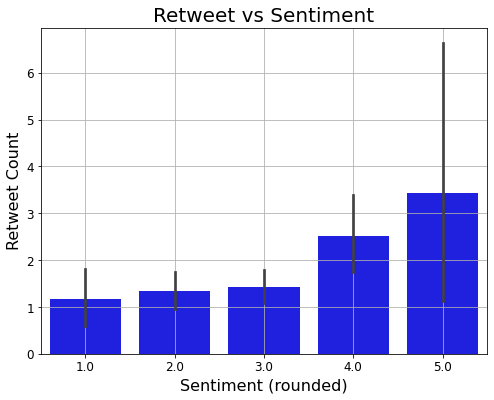

In [21]:
fig = plt.figure(figsize = (8,6))
sns.barplot(data = df, y = 'retweet_count', x = 'star', color = "blue")
plt.xlabel('Sentiment (rounded)', fontsize = 16)
plt.ylabel('Retweet Count', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Retweet vs Sentiment", fontsize = 20)
plt.grid()
#plt.yscale("log")
plt.show()

Insight: The higher sentiment tweets are retweeted more. 

##### Top 5 positive and negative tweets

In [22]:
ndisplay = 5

print(f"Top {ndisplay} Most Positive Tweets")
df_display = df.sort_values(by = ['sentiment'], ascending = False)
c=0
for index,row in df_display.iterrows():
    c+=1
    text = codecs.decode(row.text, 'unicode_escape')
    print(f"\tsentiment = {row.sentiment:.2f}: {text}")
    if c>=ndisplay:break

Top 5 Most Positive Tweets
	sentiment = 4.92: There is a fantastic documentary about the #ghostofkiev called "The Greatest Story Never Told". It's on Odysee, I believe. Highly recommended!
	sentiment = 4.91: @Ghost_of_Kiev perfect absolutely perfect
	sentiment = 4.90: Best nickname of all time. #ghostofkiev https://t.co/1Ky7thV3eI
	sentiment = 4.89: One of my heroes. These days we have a lot of them! The ghost of Kiev, a man who saved many innocent Ukrainians in this Russian aggression
#Ukraine #ghostofkiev https://t.co/z2KOO4GK0c
	sentiment = 4.89: One of my heroes. These days we have a lot of them! The ghost of Kiev, a man who saved many innocent Ukrainians in this Russian aggression
#Ukraine #ghostofkiev https://t.co/z2KOO4GK0c


In [23]:
ndisplay = 5

print(f"Top {ndisplay} Most Negative Tweets")
df_display = df.sort_values(by = ['sentiment'], ascending = True)
c=0
for index,row in df_display.iterrows():
    c+=1
    text = codecs.decode(row.text, 'unicode_escape')
    print(f"\tsentiment = {row.sentiment:.2f}: {text}")
    if c>=ndisplay:break

Top 5 Most Negative Tweets
	sentiment = 1.02: Absolute crap. What sort of nonsense is this? ð¤£ Which "Fighter  Jets" are EU countries going to provide? Who will fly them? Ghost of Kiev? Verified handles are spreading propaganda &amp; information warfare. ð @MacaesBruno @IAPonomarenko @apmassaro3  #RussiaUkraineConflict https://t.co/kSSPJ8QPlb
	sentiment = 1.03: @baileylinny4 @PodcastZed This is possibly the dumbest shit Iâve ever seen. The mental gymnastics are unreal. Iâll take the Ghost of Kiev any day over this garbage.
	sentiment = 1.03: @Ghost_of_Kiev This is absolutely horrific, fuck! horrible Loss of life ð i  hope this shit would end
	sentiment = 1.05: holy shit that mendeloid nazi is so annoying. none of his ratios are organic, he refuses to debate haz in person, and yet he dances in victory like a pigeon playing chess.

this is the most delusional copium i have ever witnessed since ghost of kiev
	sentiment = 1.05: @Ghost_of_Kiev All this death on behalf of one man

#Clustering Tweets

#####IFIDF Clustering

In [24]:
#TFIDF  
tfidf_vectorizer = TfidfVectorizer(min_df=5, stop_words = 'english')
tfidf_embedding = tfidf_vectorizer.fit_transform(df.text_clean) #takes text documents and converts to a TF/TFIDF embedding
#Fit each tweet to a vector 
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

nvocab = len(tfidf_feature_names)
ntweets = len(df.text_clean)
print(f"{ntweets} tweets, {nvocab} words in vocabulary")

26693 tweets, 5853 words in vocabulary


#####Umap TfIDF Clustering

In [25]:
%%time
#UMAP Embedding
umap_tfidf_embedding = umap.UMAP(n_components = 2, metric = 'hellinger').fit_transform(tfidf_embedding)

#using Z-score -> python package stats 
umap_tfidf_embedding = stats.zscore(umap_tfidf_embedding, nan_policy = 'omit')

#Add UMAP Embeddings to DataFrame
df['umap_tfidf_x'] = umap_tfidf_embedding[:,0]
df['umap_tfidf_y'] = umap_tfidf_embedding[:,1]


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
/usr/l

CPU times: user 2min 15s, sys: 2.44 s, total: 2min 17s
Wall time: 1min 25s


#####K-Means Clustering (3 clusters)

In [26]:
n_umap_clusters = 3

kmeans_label_umap = cluster.KMeans(n_clusters=n_umap_clusters).fit_predict(np.nan_to_num(umap_tfidf_embedding))
df['kmeans_label_umap'] = [str(x) for x in kmeans_label_umap]

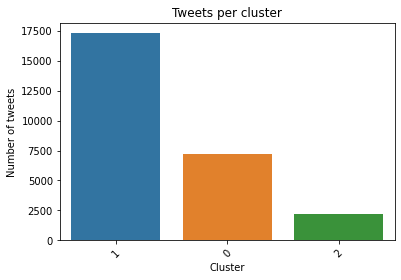

In [27]:
    sns.countplot(data=df, x = "kmeans_label_umap")
    plt.title(f"Tweets per cluster")
    plt.xticks(rotation=45)
    plt.ylabel("Number of tweets")
    plt.xlabel("Cluster")
    plt.show()

#####Sentiment for each Cluster

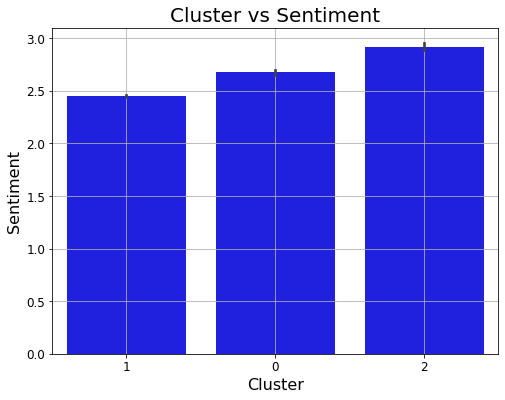

In [28]:
fig = plt.figure(figsize = (8,6))
sns.barplot(data = df, y = 'star', x = 'kmeans_label_umap', color = "blue")
plt.xlabel('Cluster', fontsize = 16)
plt.ylabel('Sentiment', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Cluster vs Sentiment", fontsize = 20)
plt.grid()
#plt.yscale("log")
plt.show()

#####Wordcloud for each cluster

In [29]:
def kmeans_wordcloud_userhist(df, cluster_label_column,stopwords):
    print(cluster_label_column)
    for k in np.sort(df[cluster_label_column].unique()):
        s=df[df[cluster_label_column]==k]
        text=' '.join(s.text_clean.tolist()).lower()
        wordcloud = WordCloud(stopwords=stopwords,max_font_size=150, max_words=100, background_color="white",width=1000, height=600)
        wordcloud.generate(text)

        print(f"\n\tCluster {k} has {len(s)} tweets")
        plt.figure(figsize = (16,4))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    return 1

In [30]:
stopwords = set(STOPWORDS)
stopwords.add("Ghost")
stopwords.add("Kiev")
stopwords.add("Ghostofkiev")
stopwords.add("Ukraine")
stopwords.add("Ukrainian")
stopwords.add("Russia")

kmeans_label_umap

	Cluster 0 has 7188 tweets


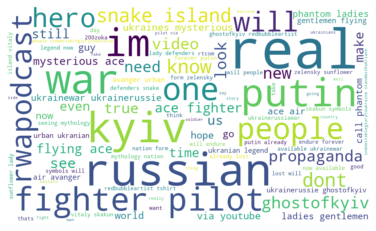


	Cluster 1 has 17314 tweets


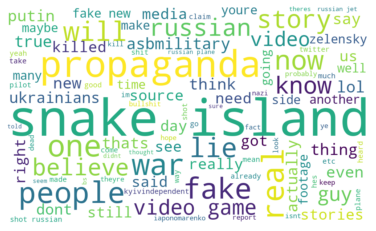


	Cluster 2 has 2191 tweets


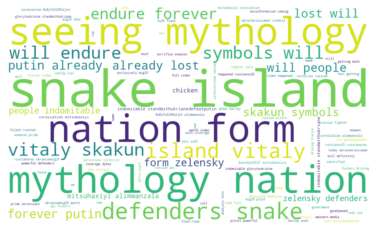

1

In [31]:


cluster_label_column= 'kmeans_label_umap'
kmeans_wordcloud_userhist(df,cluster_label_column,stopwords )

In [32]:
from google.colab import files

df.to_csv('gok_processed.csv', encoding = 'utf-8-sig') 
files.download('gok_processed.csv')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!jupyter nbconvert --to HTML FinalProject.ipynb

[NbConvertApp] Converting notebook FinalProject.ipynb to HTML
[NbConvertApp] Writing 2095350 bytes to FinalProject.html
